# Analyze the loss based on the simulations runtime

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

os.environ['JAX_PLATFORM_NAME'] = "cpu"
os.environ['JAX_PLATFORMS'] = "cpu"

In [2]:
import jax.numpy as jnp
import jax

import numpy as onp

import matplotlib.pyplot as plt

from simulation.simulate_full import run_entire_simulation

import analyzers.loss as loss_anaylzer
import analyzers.database as database

/home/florian/anaconda3/envs/jaxidp/lib/python3.11/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [3]:
scan_space = jnp.linspace(3.0000, 3.0001, 8)
runtime_values = onp.array([12, 20, 28, 36, 44, 52, 60, 68, 76, 84, 92, 100, 108, 116, 124, 132])
steps = runtime_values * 1000 // 2

In [4]:
def get_sim_result(lj_sigma_oo, runtime):
    return run_entire_simulation(lj_sigma_oo, runtime, 6, 100, 100, 1)

In [4]:
database.set_filename("../data/loss_analyzer/runtime_scan.npz")

Calculate losses over the scan space for each runtime from the array

In [ ]:
all_losses = []

for n_steps in steps:
    existing_keys = database.get_existing_keys()
    if n_steps in existing_keys:
        print(f"Skipping {n_steps}, was already computed")
        continue

    print(f"=== Running for {n_steps} steps ({n_steps // 500}ps) ===")
    reference = get_sim_result(3.188, n_steps)
    losses = []
    for lj_sigma_oo in scan_space:
        pattern = get_sim_result(lj_sigma_oo, n_steps)
        loss = loss_anaylzer.L1_loss(pattern, reference)
        losses.append(loss)
        
    jitter = loss_anaylzer.get_loss_jitter(losses)
    print(f"Jitter: {jitter}")

    database.save_intermediate_result(n_steps, losses)

# Plot
Skip previous if data is already available

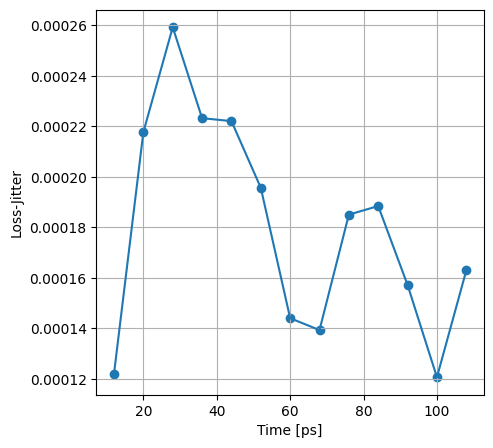

In [6]:
keys, values = database.load_result()
jitter_values = [loss_anaylzer.get_loss_jitter(v) for v in values]

plt.plot(keys / 500, jitter_values)
plt.scatter(keys / 500, jitter_values)
plt.xlabel("Time [ps]")
plt.ylabel("Loss-Jitter")

plt.gcf().set_size_inches(5, 5)
plt.grid()
plt.savefig("../plots/analysis_loss_runtime.svg")
plt.show()